## LV analysis

Increased pupil size is associated with improved stimulus discrimibaility, reduced trial-trial variability, and increased gain. Both first- and second-order changes in response statistics contribute to discriminability effect.

** Questions: **
* Are changes in trial-trial variability low dimensional? e.g. can a single latent variable account for changes in noise correlations and discriminability between large and small pupil?


In [1]:
# add hellerc code repository to python path
import sys
sys.path.append('/auto/users/hellerc/code/projects/nat_pupil_ms/')
sys.path.append('/auto/users/hellerc/code/')
import charlieTools.statistics as stats
import charlieTools.preprocessing as preproc
import charlieTools.discrimination_tools as di
import charlieTools.plotting as cplt
# import loading tools from hellerc directory imported above
import load_results as ld

# nems modules
import nems.db as nd
import nems.xforms as xforms
import nems.xform_helper as xhelp
import nems_lbhb.plots as plots

# general python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.decomposition import PCA

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-03-18 114123.log


### LV model

#### xforms modelstring  (single latent variable)
`ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-aev_stategain.SxR-lv.1xR.f.pred-stategain.2xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0`

#### xforms modelstring (two latent variables)
`ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-aev_stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0`

#### xforms modelstring (constrain LV power to correlate with pupil size, set hyperparameter to 0.2)
`ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-aev_stategain.SxR-lv.1xR.f.pred-stategain.2xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,2`



In [2]:
# define lv modelstrings
xlv1a0 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.1xR.f.pred-stategain.2xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0'
xlv1a01 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.1xR.f.pred-stategain.2xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,1'
xlv1a02 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.1xR.f.pred-stategain.2xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,2'
xlv1a03 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.1xR.f.pred-stategain.2xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,3'
    
xlv2a0 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0'
xlv2a01 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,1'
xlv2a02 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,2'
xlv2a03 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,3'
    
xlv3a0 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.3xR.f3.pred-stategain.4xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0'
xlv3a01 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.3xR.f3.pred-stategain.4xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,1'
xlv3a02 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.3xR.f3.pred-stategain.4xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,2'
xlv3a03 = 'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-' \
            'aev_stategain.SxR-lv.3xR.f3.pred-stategain.4xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0,3'

## Noise Correlation Results

In [3]:
# define LV model
xforms_modelname = xlv2a01
    
# define correction method
corr_method = '_rm1' # rm1 means remove state variable with regression post hoc.
                     # rm2 means remove state variable by subtracting xforms model prediction from residuals

# load raw noise correlations
rsc = ld.load_noise_correlation('rsc')

# load pupil (first-order) corrected noise correlations
rsc_pr = ld.load_noise_correlation('rsc_pr'+corr_method)

# load pupil + lv (first+second order) corrected noise correlations
rsc_lvr = ld.load_noise_correlation('rsc_pr_lvr'+corr_method, xforms_model=xforms_modelname)

# remove pairs of neurons that don't have sig corr in at least one condition
#rsc = rsc[(rsc.p_bp<0.05) | (rsc.p_sp<0.05)]
#rsc_pr = rsc_pr[(rsc_pr.p_bp<0.05) | (rsc_pr.p_sp<0.05)]
#rsc_lvr = rsc_lvr[(rsc_lvr.p_bp<0.05) | (rsc_lvr.p_sp<0.05)]

# data frames contain overall noise corr (all), big pupil (bp) and small pupil (sp)
# in addition, they include a pvalue for each corr coef. e.g. p_all = pvalue for the overall noise corr
rsc.head()

,all,p_all,bp,p_bp,sp,p_sp,site
AMT005c-02-1_AMT005c-02-2,0.228111,1.249624e-15,0.187934,3.566301e-06,0.228639,1.478856e-08,AMT005c
AMT005c-02-1_AMT005c-04-1,-0.017971,5.339879e-01,0.029332,4.732810e-01,-0.101500,1.286540e-02,AMT005c
AMT005c-02-1_AMT005c-08-1,0.203515,1.101230e-12,0.127631,1.732639e-03,0.180894,8.250459e-06,AMT005c
AMT005c-02-1_AMT005c-11-1,0.289065,1.579410e-24,0.291944,2.969866e-13,0.281914,2.003799e-12,AMT005c
AMT005c-02-1_AMT005c-12-1,0.121506,2.439124e-05,0.178992,1.029290e-05,0.034064,4.049046e-01,AMT005c


In [4]:
# find which sites have sig change one way or the other between big / small pupil
rsc['site_pval'] = np.nan
rsc_pr['site_pval'] = np.nan
rsc_lvr['site_pval'] = np.nan
for s in rsc.site.unique():
    _, p_raw = ss.wilcoxon(rsc[rsc.site==s].bp, rsc[rsc.site==s].sp)
    _, p_pr = ss.wilcoxon(rsc_pr[rsc_pr.site==s].bp, rsc_pr[rsc_pr.site==s].sp)
    _, p_lvr = ss.wilcoxon(rsc_lvr[rsc_lvr.site==s].bp, rsc_lvr[rsc_lvr.site==s].sp)
    
    rsc.loc[rsc.site==s, 'site_pval'] = p_raw
    rsc_pr.loc[rsc_pr.site==s, 'site_pval'] = p_pr
    rsc_lvr.loc[rsc_lvr.site==s, 'site_pval'] = p_lvr
    
    

/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/hellerc/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2389: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


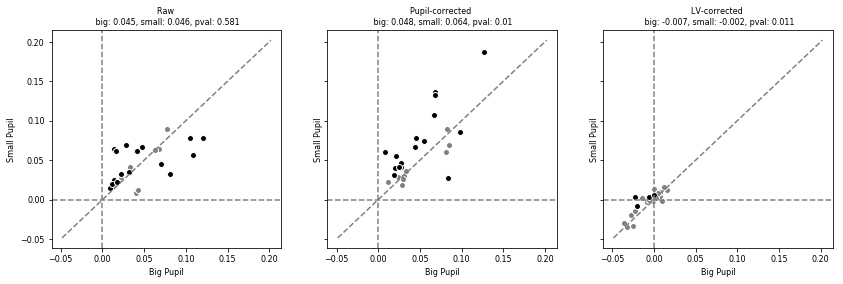

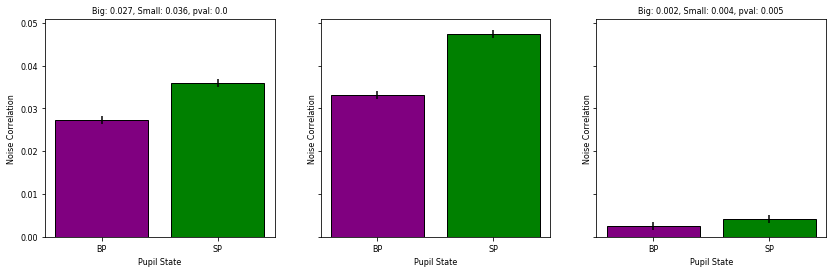

In [5]:
# plot results per site 
f, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)


big = np.round(rsc.groupby(by='site').mean()['bp'].mean(), 3)
small = np.round(rsc.groupby(by='site').mean()['sp'].mean(), 3)
pval = np.round(ss.wilcoxon(rsc.groupby(by='site').mean()['bp'], rsc.groupby(by='site').mean()['sp']).pvalue, 3)
ax[0].set_title("Raw \n big: {0}, small: {1}, pval: {2}".format(big, small, pval))
ax[0].scatter(rsc.groupby(by='site').mean()['bp'], 
              rsc.groupby(by='site').mean()['sp'], color='grey', edgecolor='white')


big = np.round(rsc_pr.groupby(by='site').mean()['bp'].mean(), 3)
small = np.round(rsc_pr.groupby(by='site').mean()['sp'].mean(), 3)
pval = np.round(ss.wilcoxon(rsc_pr.groupby(by='site').mean()['bp'], rsc_pr.groupby(by='site').mean()['sp']).pvalue, 3)
ax[1].set_title("Pupil-corrected \n big: {0}, small: {1}, pval: {2}".format(big, small, pval))
ax[1].scatter(rsc_pr.groupby(by='site').mean()['bp'], 
              rsc_pr.groupby(by='site').mean()['sp'], color='grey', edgecolor='white')

                
big = np.round(rsc_lvr.groupby(by='site').mean()['bp'].mean(), 3)
small = np.round(rsc_lvr.groupby(by='site').mean()['sp'].mean(), 3)
pval = np.round(ss.wilcoxon(rsc_lvr.groupby(by='site').mean()['bp'], rsc_lvr.groupby(by='site').mean()['sp']).pvalue, 3)
ax[2].set_title("LV-corrected \n big: {0}, small: {1}, pval: {2}".format(big, small, pval))
ax[2].scatter(rsc_lvr.groupby(by='site').mean()['bp'], 
              rsc_lvr.groupby(by='site').mean()['sp'], color='grey', edgecolor='white')

# plot sig sites in black
ax[0].scatter(rsc[rsc.site_pval<=0.05].groupby(by='site').mean()['bp'], 
              rsc[rsc.site_pval<=0.05].groupby(by='site').mean()['sp'], color='k', edgecolor='white')

ax[1].scatter(rsc_pr[rsc_pr.site_pval<=0.05].groupby(by='site').mean()['bp'], 
              rsc_pr[rsc_pr.site_pval<=0.05].groupby(by='site').mean()['sp'], color='k', edgecolor='white')

ax[2].scatter(rsc_lvr[rsc_lvr.site_pval<=0.05].groupby(by='site').mean()['bp'], 
              rsc_lvr[rsc_lvr.site_pval<=0.05].groupby(by='site').mean()['sp'], color='k', edgecolor='white')
   

mi = np.min(ax[2].get_xlim() + ax[2].get_ylim())
ma = np.max(ax[2].get_xlim() + ax[2].get_ylim())
for a in ax:
    a.set_xlabel('Big Pupil')
    a.set_ylabel('Small Pupil')
    a.axhline(0, linestyle='--', color='grey')
    a.axvline(0, linestyle='--', color='grey')
    a.plot([mi, ma], [mi, ma], 'grey', linestyle='--')
    
    
# plot results over all pairs, ingnoring site id
f, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

ax[0].bar([0, 1], [rsc['bp'].mean(), rsc['sp'].mean()],
                yerr=[rsc['bp'].sem(), rsc['sp'].sem()], edgecolor='k',
                color=['purple', 'green'])
bp = np.round(rsc['bp'].mean(), 3)
sp = np.round(rsc['sp'].mean(), 3)
pval = np.round(ss.wilcoxon(rsc['bp'], rsc['sp']).pvalue, 3)
ax[0].set_title('Big: {0}, Small: {1}, pval: {2}'.format(bp, sp, pval))

ax[1].bar([0, 1], [rsc_pr['bp'].mean(), rsc_pr['sp'].mean()],
                yerr=[rsc_pr['bp'].sem(), rsc_pr['sp'].sem()], edgecolor='k',
                color=['purple', 'green'])
bp = np.round(rsc_pr['bp'].mean(), 3)
sp = np.round(rsc_pr['sp'].mean(), 3)
pval = np.round(ss.wilcoxon(rsc_pr['bp'], rsc_pr['sp']).pvalue, 3)
ax[2].set_title('Big: {0}, Small: {1}, pval: {2}'.format(bp, sp, pval))

ax[2].bar([0, 1], [rsc_lvr['bp'].mean(), rsc_lvr['sp'].mean()],
                yerr=[rsc_lvr['bp'].sem(), rsc_lvr['sp'].sem()], edgecolor='k',
                color=['purple', 'green'])
bp = np.round(rsc_lvr['bp'].mean(), 3)
sp = np.round(rsc_lvr['sp'].mean(), 3)
pval = np.round(ss.wilcoxon(rsc_lvr['bp'], rsc_lvr['sp']).pvalue, 3)
ax[2].set_title('Big: {0}, Small: {1}, pval: {2}'.format(bp, sp, pval))

for a in ax:
    a.set_xlabel('Pupil State')
    a.set_ylabel('Noise Correlation')
    a.set_xticks([0, 1])
    a.set_xticklabels(['BP', 'SP'])

    
plt.show()

### QUESTION(s): 
* Do we need to address inconsistenty across sites?
* LV basically removes all noise correlation. Does this sort of make a decoding result trivial? Pupil dimension is not "special"? Counter argument is that despite the small change, there is still a sig. change between large/small pupil.

##### closer look at outlier sites
* sites where noise corr. larger in big pupil for the raw data. One idea of why this might be - first order effects are large/dominant, and for these sites pupil is split in such a way that pupil flucutates a lot during the big pupil split. This would explain why things are cleaned up when moving to the pupil-corrected data in some cases. 

In [6]:
# outlier sites
grouped = rsc.groupby(by='site').mean()
grouped_pr = rsc_pr.groupby(by='site').mean()
outlier = grouped[((grouped.bp - grouped.sp) > 0) & (grouped.site_pval <= 0.05)]
print("{0} / {1} sites are 'outliers'".format(outlier.shape[0], grouped.shape[0]))
pd.concat([outlier, grouped_pr.loc[outlier.index]], axis=1)[['all', 'bp', 'sp']]

5 / 25 sites are 'outliers'


,all,all,bp,bp,sp,sp
site,,,,,,
AMT005c,0.097220,0.097819,0.104702,0.084541,0.077919,0.069595
AMT019a,0.108010,0.120900,0.121060,0.127237,0.077826,0.187210
AMT021b,0.065299,0.051176,0.070283,0.082609,0.044734,0.089665
BRT038b,0.081367,0.072253,0.080469,0.081229,0.031869,0.059761
TAR017b,0.106656,0.087764,0.108346,0.098215,0.056759,0.085781


## Discriminability Results

#### dprime model notes:
```
bp / sp = big pupil / small pupil
sia / ssa = state indpendent decoding axis / state-specific decoding axis
sim1 = fix second order stats
sim2 = fix first order stats
pr = pupil-regressed
lvr = latent variable-regressed
uMatch = simulate relative the stats measured over all data (rather than relative to small pupil, for ex)
```

In [7]:
from dprime.load_dprime import load_dprime, filter_df, get_quad_mask

# choose correction method
cm = 'rm1'

# =========================== load dprime results =================================

# dprime overall
dp_all = load_dprime('dprime_all')
dp_sp = load_dprime('dprime_sp_sia')

# raw dprime results
raw_bp = load_dprime('dprime_bp_sia')
raw_sp = load_dprime('dprime_sp_sia')

# pupil-corrected results
bp_pr = load_dprime('dprime_bp_pr_sia_{}'.format(cm))
sp_pr = load_dprime('dprime_sp_pr_sia_{}'.format(cm))

# SIMULATED RESULTS

# raw
sim1_bp = load_dprime('dprime_bp_sim1_sia_uMatch')
sim1_sp = load_dprime('dprime_sp_sim1_sia_uMatch')
sim2_bp = load_dprime('dprime_bp_sim2_sia_uMatch')
sim2_sp = load_dprime('dprime_sp_sim2_sia_uMatch')

# pupil-corrected
sim1_bp_pr = load_dprime('dprime_bp_pr_sim1_sia_{}_uMatch'.format(cm))
sim1_sp_pr = load_dprime('dprime_sp_pr_sim1_sia_{}_uMatch'.format(cm))
sim2_bp_pr = load_dprime('dprime_bp_pr_sim2_sia_{}_uMatch'.format(cm))
sim2_sp_pr = load_dprime('dprime_sp_pr_sim2_sia_{}_uMatch'.format(cm))

df_list = [raw_bp, raw_sp, bp_pr, sp_pr, sim1_bp, sim1_sp, sim2_bp, sim2_sp,
          sim1_bp_pr, sim1_sp_pr, sim2_bp_pr, sim2_sp_pr]
[raw_bp, raw_sp, bp_pr, sp_pr, sim1_bp, sim1_sp, sim2_bp, sim2_sp,
          sim1_bp_pr, sim1_sp_pr, sim2_bp_pr, sim2_sp_pr] = filter_df(df_list, dp_all, dp_sp)

In [8]:
# load LV-corrected models separate so you don't have to reload everything if you want to try a diff LV model

# choose which xforms model to load (for a more systematic exploration of which is best,
# see other notebook(s): dprime_vs_lvModels and rsc_vs_lvModels)
xforms_model = xlv2a0

# LV-corrected results
bp_lvr = load_dprime('dprime_bp_pr_lvr_sia_{}'.format(cm), xforms_model=xforms_model)
sp_lvr = load_dprime('dprime_sp_pr_lvr_sia_{}'.format(cm), xforms_model=xforms_model)

# LV-corrected
sim1_bp_lvr = load_dprime('dprime_bp_pr_lvr_sim1_sia_{}_uMatch'.format(cm), xforms_model=xforms_model)
sim1_sp_lvr = load_dprime('dprime_sp_pr_lvr_sim1_sia_{}_uMatch'.format(cm), xforms_model=xforms_model)
sim2_bp_lvr = load_dprime('dprime_bp_pr_lvr_sim2_sia_{}_uMatch'.format(cm), xforms_model=xforms_model)
sim2_sp_lvr = load_dprime('dprime_sp_pr_lvr_sim2_sia_{}_uMatch'.format(cm), xforms_model=xforms_model)

df_list = [bp_lvr, sp_lvr, sim1_bp_lvr, sim1_sp_lvr, sim2_bp_lvr, sim2_sp_lvr, dp_all, dp_sp]
[bp_lvr, sp_lvr, sim1_bp_lvr, sim1_sp_lvr, sim2_bp_lvr, sim2_sp_lvr, dp_all, dp_sp] = filter_df(df_list, dp_all, dp_sp)

### Plot overall dprime results, per site
* stats in the figures are group stats after collapsing across pairs of stimuli at each site

Text(0.5,1,'d-prime per site, lv-corrected \n big: 8.818, small: 8.937, pval: 0.527, sign test')

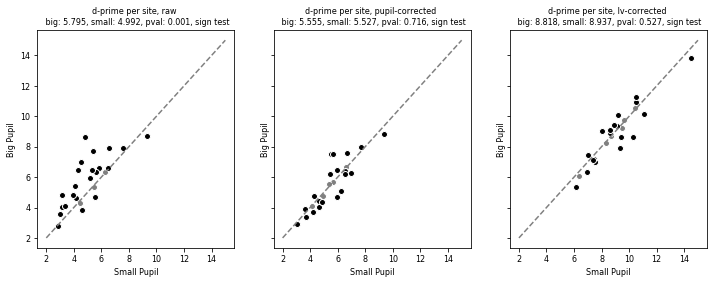

In [9]:
# get site pvals
# find which sites have sig change one way or the other between big / small pupil
raw_bp['site_pval'] = np.nan
raw_sp['site_pval'] = np.nan
for s in raw_bp.site.unique():
    _, pval = ss.wilcoxon(raw_bp[raw_bp.site==s].dprime, raw_sp[raw_sp.site==s].dprime)
    
    raw_bp.at[raw_bp.site==s, 'site_pval'] = pval
    raw_sp.at[raw_sp.site==s, 'site_pval'] = pval
    
    _, pval = ss.wilcoxon(bp_pr[bp_pr.site==s].dprime, sp_pr[sp_pr.site==s].dprime)
    
    bp_pr.at[bp_pr.site==s, 'site_pval'] = pval
    sp_pr.at[sp_pr.site==s, 'site_pval'] = pval
    
    _, pval = ss.wilcoxon(bp_lvr[bp_lvr.site==s].dprime, sp_lvr[sp_lvr.site==s].dprime)
    
    bp_lvr.at[bp_lvr.site==s, 'site_pval'] = pval
    sp_lvr.at[sp_lvr.site==s, 'site_pval'] = pval

# plot the overall dprime result, for reference
f, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax[0].scatter(raw_sp.groupby(by='site').mean()['dprime'],
           raw_bp.groupby(by='site').mean()['dprime'], color='grey', edgecolor='white')
ax[0].scatter(raw_sp[raw_sp.site_pval<=0.05].groupby(by='site').mean()['dprime'],
           raw_bp[raw_bp.site_pval<=0.05].groupby(by='site').mean()['dprime'], color='k', edgecolor='white')
ax[0].plot([2, 15], [2, 15], 'grey', linestyle='--')
ax[0].set_ylabel('Big Pupil')
ax[0].set_xlabel('Small Pupil')

big = np.round(raw_bp.groupby(by='site').mean()['dprime'].mean(), 3)
small = np.round(raw_sp.groupby(by='site').mean()['dprime'].mean(), 3)
pval = np.round(ss.wilcoxon(raw_bp.groupby(by='site').mean()['dprime'], raw_sp.groupby(by='site').mean()['dprime']).pvalue, 3)
ax[0].set_title('d-prime per site, raw \n big: {0}, small: {1}, pval: {2}, sign test'.format(big, small, pval))


ax[1].scatter(sp_pr.groupby(by='site').mean()['dprime'],
           bp_pr.groupby(by='site').mean()['dprime'], color='grey', edgecolor='white')
ax[1].scatter(sp_pr[sp_pr.site_pval<=0.05].groupby(by='site').mean()['dprime'],
           bp_pr[bp_pr.site_pval<=0.05].groupby(by='site').mean()['dprime'], color='k', edgecolor='white')
ax[1].plot([2, 15], [2, 15], 'grey', linestyle='--')
ax[1].set_ylabel('Big Pupil')
ax[1].set_xlabel('Small Pupil')

big = np.round(bp_pr.groupby(by='site').mean()['dprime'].mean(), 3)
small = np.round(sp_pr.groupby(by='site').mean()['dprime'].mean(), 3)
pval = np.round(ss.wilcoxon(bp_pr.groupby(by='site').mean()['dprime'], sp_pr.groupby(by='site').mean()['dprime']).pvalue, 3)
ax[1].set_title('d-prime per site, pupil-corrected \n big: {0}, small: {1}, pval: {2}, sign test'.format(big, small, pval))


ax[2].scatter(sp_lvr.groupby(by='site').mean()['dprime'],
           bp_lvr.groupby(by='site').mean()['dprime'], color='grey', edgecolor='white')
ax[2].scatter(sp_lvr[sp_lvr.site_pval<=0.05].groupby(by='site').mean()['dprime'],
           bp_lvr[bp_lvr.site_pval<=0.05].groupby(by='site').mean()['dprime'], color='k', edgecolor='white')
ax[2].plot([2, 15], [2, 15], 'grey', linestyle='--')
ax[2].set_ylabel('Big Pupil')
ax[2].set_xlabel('Small Pupil')

big = np.round(bp_lvr.groupby(by='site').mean()['dprime'].mean(), 3)
small = np.round(sp_lvr.groupby(by='site').mean()['dprime'].mean(), 3)
pval = np.round(ss.wilcoxon(bp_lvr.groupby(by='site').mean()['dprime'], sp_lvr.groupby(by='site').mean()['dprime']).pvalue, 3)
ax[2].set_title('d-prime per site, lv-corrected \n big: {0}, small: {1}, pval: {2}, sign test'.format(big, small, pval))


### Now re-make plot above only for top two quadrants
* (high signal / noise overlap pairs of stimuli)

Text(0.5,0.98,'Top two quadrants only')

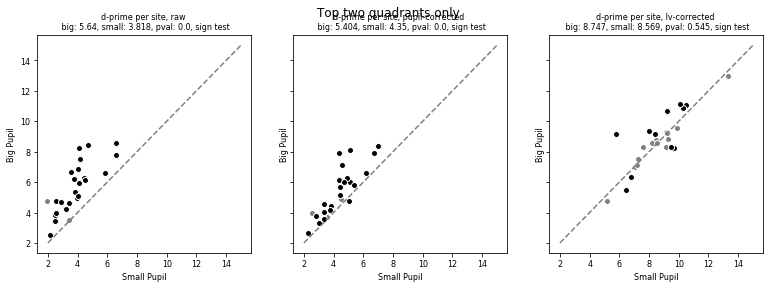

In [10]:
m1 = get_quad_mask(dp_all, dp_sp, 1)
m2 = get_quad_mask(dp_all, dp_sp, 2)
m = m1 | m2

# get site pvals
# find which sites have sig change one way or the other between big / small pupil
raw_bp['site_pval'] = np.nan
raw_sp['site_pval'] = np.nan
for s in raw_bp.site.unique():
    _, pval = stats._do_jackknife_ttest(raw_bp[m][raw_bp[m].site==s].dprime - raw_sp[m][raw_sp[m].site==s].dprime, 0)
    
    raw_bp.at[raw_bp.site==s, 'site_pval'] = pval
    raw_sp.at[raw_sp.site==s, 'site_pval'] = pval
    
    _, pval = stats._do_jackknife_ttest(bp_pr[m][bp_pr[m].site==s].dprime - sp_pr[m][sp_pr[m].site==s].dprime, 0)
    
    bp_pr.at[bp_pr.site==s, 'site_pval'] = pval
    sp_pr.at[sp_pr.site==s, 'site_pval'] = pval
    
    _, pval = stats._do_jackknife_ttest(bp_lvr[m][bp_lvr[m].site==s].dprime - sp_lvr[m][sp_lvr[m].site==s].dprime, 0)
    
    bp_lvr.at[bp_lvr.site==s, 'site_pval'] = pval
    sp_lvr.at[sp_lvr.site==s, 'site_pval'] = pval

# plot the overall dprime result, for reference
f, ax = plt.subplots(1, 3, figsize=(13, 4), sharex=True, sharey=True)

ax[0].scatter(raw_sp[m].groupby(by='site').mean()['dprime'],
           raw_bp[m].groupby(by='site').mean()['dprime'], color='grey', edgecolor='white')
ax[0].scatter(raw_sp[m][raw_sp[m].site_pval<=0.05].groupby(by='site').mean()['dprime'],
           raw_bp[m][raw_bp[m].site_pval<=0.05].groupby(by='site').mean()['dprime'], color='k', edgecolor='white')
ax[0].plot([2, 15], [2, 15], 'grey', linestyle='--')
ax[0].set_ylabel('Big Pupil')
ax[0].set_xlabel('Small Pupil')

big = np.round(raw_bp[m].groupby(by='site').mean()['dprime'].mean(), 3)
small = np.round(raw_sp[m].groupby(by='site').mean()['dprime'].mean(), 3)
pval = np.round(ss.wilcoxon(raw_bp[m].groupby(by='site').mean()['dprime'], raw_sp[m].groupby(by='site').mean()['dprime']).pvalue, 3)
ax[0].set_title('d-prime per site, raw \n big: {0}, small: {1}, pval: {2}, sign test'.format(big, small, pval))


ax[1].scatter(sp_pr[m].groupby(by='site').mean()['dprime'],
           bp_pr[m].groupby(by='site').mean()['dprime'], color='grey', edgecolor='white')
ax[1].scatter(sp_pr[m][sp_pr[m].site_pval<=0.05].groupby(by='site').mean()['dprime'],
           bp_pr[m][bp_pr[m].site_pval<=0.05].groupby(by='site').mean()['dprime'], color='k', edgecolor='white')
ax[1].plot([2, 15], [2, 15], 'grey', linestyle='--')
ax[1].set_ylabel('Big Pupil')
ax[1].set_xlabel('Small Pupil')

big = np.round(bp_pr[m].groupby(by='site').mean()['dprime'].mean(), 3)
small = np.round(sp_pr[m].groupby(by='site').mean()['dprime'].mean(), 3)
pval = np.round(ss.wilcoxon(bp_pr[m].groupby(by='site').mean()['dprime'], sp_pr[m].groupby(by='site').mean()['dprime']).pvalue, 3)
ax[1].set_title('d-prime per site, pupil-corrected \n big: {0}, small: {1}, pval: {2}, sign test'.format(big, small, pval))


ax[2].scatter(sp_lvr[m].groupby(by='site').mean()['dprime'],
           bp_lvr[m].groupby(by='site').mean()['dprime'], color='grey', edgecolor='white')
ax[2].scatter(sp_lvr[m][sp_lvr[m].site_pval<=0.05].groupby(by='site').mean()['dprime'],
           bp_lvr[m][bp_lvr[m].site_pval<=0.05].groupby(by='site').mean()['dprime'], color='k', edgecolor='white')
ax[2].plot([2, 15], [2, 15], 'grey', linestyle='--')
ax[2].set_ylabel('Big Pupil')
ax[2].set_xlabel('Small Pupil')

big = np.round(bp_lvr[m].groupby(by='site').mean()['dprime'].mean(), 3)
small = np.round(sp_lvr[m].groupby(by='site').mean()['dprime'].mean(), 3)
pval = np.round(ss.wilcoxon(bp_lvr[m].groupby(by='site').mean()['dprime'], sp_lvr[m].groupby(by='site').mean()['dprime']).pvalue, 3)
ax[2].set_title('d-prime per site, lv-corrected \n big: {0}, small: {1}, pval: {2}, sign test'.format(big, small, pval))

f.suptitle("Top two quadrants only")

##### Summary of fields returned in the dprime analysis:
```
def compute_dprime_from_dicts(d1, d2=None, norm=True, LDA=True, spont_bins=None, equal_tbin=False, verbose=False):
    
    For case when you've folded response into epoch dictionary with keys
    = epoch name and values = numpy arrays (reps x neuron x time).

    d2 is optional. If included, it's used to compute the decoding axis.

    spont_bins is optional. If specified, refers to number of prestimulus bins
    of silence that precede each epoch. These will be labeled as such in the
    output data frame

    equal_tbin. Optional. If True, only compare epochs of equivalent time bins. 
        For example: compare REF_0 to TAR_0 but NOT REF_0 to TAR_1

    CRH update docstring 02/03/2020
    returns df with the following fields per pair of stimuli:

        d1 (or other) results:
            dprime: discriminability 
            category: specify if sound vs. sound comparison or sound vs. spont etc.
            pc1_var_explained: variance explained of first PC of residuals for *d1*
            pc1_proj_on_dec: cosine similarity between first PC of residuals for *d1* and decoding axis
            stim1_pc1_proj_on_dec: same as ^ for only data from first stimulus in pair
            stim2_pc1_proj_on_dec: "^" for second stimulus in pair
            stim1_pc1_proj_on_u1: cosine similarity between pc1 of stim1 and mean of stim1
            stim2_pc1_proj_on_u2: cosine similarity between pc1 of stim2 and mean of stim2

        d2 (decoding data) stats (or d1 if d2 is None):
            similarity: cosine similarity between pairs of stimuli in *d2* (if d2 is none, this is d1)
            difference: normalized euc. distance between pairs of stimuli in *d2* (if d2 is none, this is d1)
            pc1_var_explained_all: variance explained of first PC of residuals for *d2*
            pc1_proj_on_dec_all: cosine similarity between first PC of residuals for *d2* and decoding axis
    
```

In [11]:
raw_sp.head()

,dprime,similarity,difference,category,pc1_var_explained,pc1_proj_on_dec,pc1_var_explained_all,pc1_proj_on_dec_all,stim1_pc1_proj_on_dec,stim2_pc1_proj_on_dec,stim1_pc1_proj_on_u1,stim2_pc1_proj_on_u2,site,site_pval
STIM_00cat172_rec1_geese_excerpt1.wav_10_STIM_00cat172_rec1_geese_excerpt1.wav_11,5.072740,0.911608,0.534462,sound_sound,0.262284,0.243465,0.233264,-0.406206,-0.169955,0.333874,0.614896,-0.361407,AMT005c,0.001
STIM_00cat172_rec1_geese_excerpt1.wav_10_STIM_00cat172_rec1_geese_excerpt1.wav_12,7.691185,0.885900,0.468406,sound_sound,0.260606,-0.283475,0.210113,0.108982,-0.037792,-0.374492,0.448934,0.410467,AMT005c,0.001
STIM_00cat172_rec1_geese_excerpt1.wav_10_STIM_00cat172_rec1_geese_excerpt1.wav_13,5.735746,0.868774,0.455506,sound_sound,0.294928,0.311465,0.218036,-0.005019,-0.159962,0.298243,0.572765,-0.171128,AMT005c,0.001
STIM_00cat172_rec1_geese_excerpt1.wav_10_STIM_00cat172_rec1_geese_excerpt1.wav_14,5.687777,0.917700,0.111814,sound_sound,0.278351,0.199183,0.241736,0.124397,-0.066689,-0.361674,0.727849,0.600631,AMT005c,0.001
STIM_00cat172_rec1_geese_excerpt1.wav_10_STIM_00cat172_rec1_geese_excerpt1.wav_15,4.760486,0.863991,1.711227,sound_sound,0.456470,-0.062383,0.296087,-0.110069,-0.715029,-0.063430,-0.793664,0.122060,AMT005c,0.001


### Summarize discriminability results

Text(0.5,0.98,'ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-aev_stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv_init.i0.xx1.t7-init.f0.t7.pLV0')

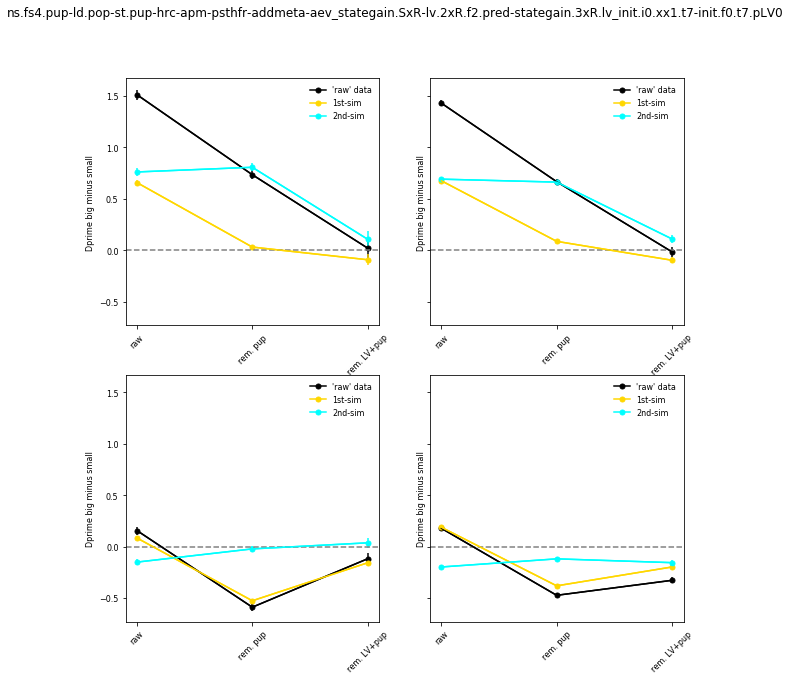

In [12]:
f, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

for a, q in zip(ax.flatten(), [2, 1, 3, 4]):
    m = get_quad_mask(dp_all, raw_sp, q)
    a.plot([0, 1, 2],
                [
                    (raw_bp['dprime'][m] - raw_sp['dprime'][m]).mean(),
                    (bp_pr['dprime'][m] - sp_pr['dprime'][m]).mean(),
                    (bp_lvr['dprime'][m] - sp_lvr['dprime'][m]).mean()
                ],
                color='k',
                marker='o',
                markersize=5,
                label="'raw' data")
    a.errorbar([0, 1, 2],
            [
                (raw_bp['dprime'][m] - raw_sp['dprime'][m]).mean(),
                (bp_pr['dprime'][m] - sp_pr['dprime'][m]).mean(),
                (bp_lvr['dprime'][m] - sp_lvr['dprime'][m]).mean()
            ],
            yerr=[
                (raw_bp['dprime'][m] - raw_sp['dprime'][m]).sem(),
                (bp_pr['dprime'][m] - sp_pr['dprime'][m]).sem(),
                (bp_lvr['dprime'][m] - sp_lvr['dprime'][m]).sem()
            ],
            color='k')

    a.plot([0, 1, 2],
                [
                    (sim1_bp['dprime'][m] - sim1_sp['dprime'][m]).mean(),
                    (sim1_bp_pr['dprime'][m] - sim1_sp_pr['dprime'][m]).mean(),
                    (sim1_bp_lvr['dprime'][m] - sim1_sp_lvr['dprime'][m]).mean()
                ],
                color='gold',
                marker='o',
                markersize=5,
                label="1st-sim")
    a.errorbar([0, 1, 2],
            [
                (sim1_bp['dprime'][m] - sim1_sp['dprime'][m]).mean(),
                (sim1_bp_pr['dprime'][m] - sim1_sp_pr['dprime'][m]).mean(),
                (sim1_bp_lvr['dprime'][m] - sim1_sp_lvr['dprime'][m]).mean()
            ],
            yerr=[
                (sim1_bp['dprime'][m] - sim1_sp['dprime'][m]).sem(),
                (sim1_bp_pr['dprime'][m] - sim1_sp_pr['dprime'][m]).sem(),
                (sim1_bp_lvr['dprime'][m] - sim1_sp_lvr['dprime'][m]).sem()
            ],
            color='gold')

    a.plot([0, 1, 2],
                [
                    (sim2_bp['dprime'][m] - sim2_sp['dprime'][m]).mean(),
                    (sim2_bp_pr['dprime'][m] - sim2_sp_pr['dprime'][m]).mean(),
                    (sim2_bp_lvr['dprime'][m] - sim2_sp_lvr['dprime'][m]).mean()
                ],
                color='cyan',
                marker='o',
                markersize=5,
                label="2nd-sim")
    a.errorbar([0, 1, 2],
            [
                (sim2_bp['dprime'][m] - sim2_sp['dprime'][m]).mean(),
                (sim2_bp_pr['dprime'][m] - sim2_sp_pr['dprime'][m]).mean(),
                (sim2_bp_lvr['dprime'][m] - sim2_sp_lvr['dprime'][m]).mean()
            ],
            yerr=[
                (sim2_bp['dprime'][m] - sim2_sp['dprime'][m]).sem(),
                (sim2_bp_pr['dprime'][m] - sim2_sp_pr['dprime'][m]).sem(),
                (sim2_bp_lvr['dprime'][m] - sim2_sp_lvr['dprime'][m]).sem()
            ],
            color='cyan')
    a.axhline(0, linestyle='--', color='grey')
    a.legend(fontsize=8, frameon=False)
    a.set_xticks([0, 1, 2])
    a.set_xticklabels(['raw', 'rem. pup', 'rem. LV+pup'], rotation=45, fontsize=8)
    a.set_ylabel('Dprime big minus small', fontsize=8)

f.suptitle(xforms_model)

#f.tight_layout()



## Example Sites
Closer look at each sites. For a given site:
* plot LV model results (LV timecourse and loadings)
* browse through pairs of stimuli. Plot in dec vs. noise space.
* Display dprime for large / small pupil in all conditions (raw, pupil-regressed, lv regressed)

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/289/DRX006b.e1:64/ns.fs4.pup-ld.pop-st.pup-hrc-apm-psthfr-addmeta-aev.stategain.SxR-lv.2xR.f2.pred-stategain.3xR.lv.init.i0.xx1.t7-init.f0.t7.pLV0.2020-03-15T190535...
[nems.xforms INFO] Evaluating: nems.xforms.init_context
[nems.xforms INFO] Evaluating: nems_lbhb.xform_wrappers.baphy_load_wrapper
[nems_lbhb.xform_wrappers INFO] loader=ns.fs4.pup
[nems_lbhb.baphy INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy INFO] Cached recording found: /auto/data/nems_db/recordings/289/DRX006b_66f2566bcab3ac06d97a0f363c788476bc843535.tgz
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) ['DRX006b-01-2', 'DRX006b-02-2', 'DRX006b-03-4', 'DRX006b-04-1', 'DRX006b-04-2', 'DRX006b-05-4', 'DRX006b-06-1', 'DRX006b-06-2', 'DRX006b-07-1', 'DRX006b-08-3', 'DRX006b-12-2', 'DRX006b-14-1', 'DRX006b-14-2', 'DRX006b-17-2', 'DRX006b-18-2', 'DRX006b-19-4', 'DRX006b-19-5', 'DRX006

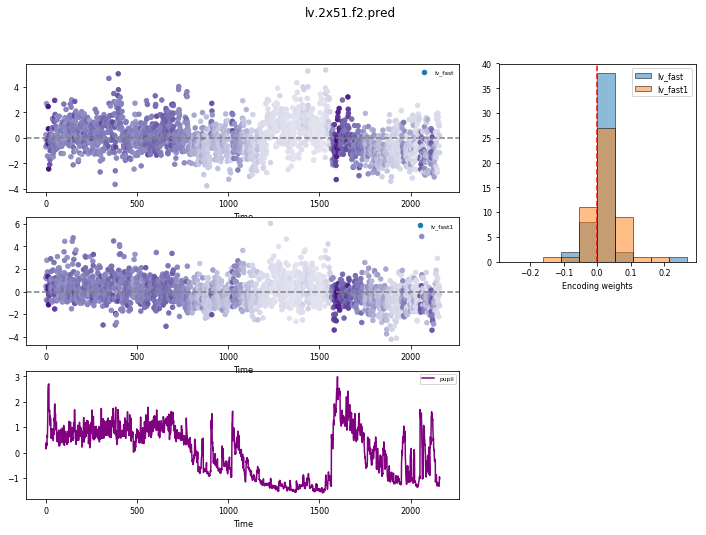

In [13]:
# load the model/rec/decoding results
site = 'DRX006b'
sitedrx = 'DRX006b.e1:64'
chan_nums = [str(i) for i in np.arange(0, 65)] #ust specify for DRX models

mn = xforms_model
df_bp = load_dprime('dprime_bp_pr_lvr_sia_{}'.format(cm), xforms_model=mn)
df_sp = load_dprime('dprime_sp_pr_lvr_sia_{}'.format(cm), xforms_model=mn)
dp_all = load_dprime('dprime_all')
dp_sp = load_dprime('dprime_sp_sia')
[df_bp, df_sp] = filter_df([df_bp, df_sp], dp_all, dp_sp)

if 'DRX' not in site:
    cellid = [c for c in nd.get_batch_cells(289).cellid if site in c][0]
elif 'DRX' in site:
    cellid = [[c for c in nd.get_batch_cells(289).cellid if (site in c) & (c.split('-')[1] in chan_nums)][0]]

xfspec,ctx = xhelp.load_model_xform(cellid, batch=289, modelname=mn)

# plot latent variable results
plots.lv_quickplot(ctx['val'], ctx['modelspec'])

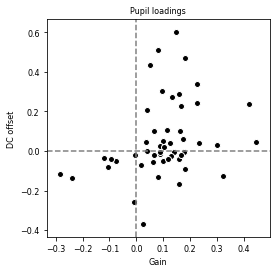

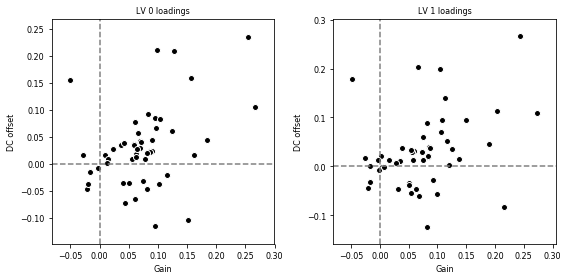

In [14]:
# plot gain / dc loadings for each LV and pupil

# pupil loadings
f, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(ctx['modelspec'].phi[0]['g'][:, 1], ctx['modelspec'].phi[0]['d'][:, 1],
               color='k', edgecolor='white')
ax.axhline(0, linestyle='--', color='grey')
ax.axvline(0, linestyle='--', color='grey')

ax.set_xlabel('Gain')
ax.set_ylabel('DC offset')
ax.set_title('Pupil loadings')

# LV loadings
nLV = ctx['val']['lv'].shape[0] - 1
f, ax = plt.subplots(1, nLV, figsize=(int(4 * nLV), 4))

if nLV == 1:
    ax = [ax]
    
for i, a in enumerate(ax):
    a.scatter(ctx['modelspec'].phi[2]['g'][:, i+1], ctx['modelspec'].phi[2]['d'][:, i+1],
               color='k', edgecolor='white')
    a.axhline(0, linestyle='--', color='grey')
    a.axvline(0, linestyle='--', color='grey')

    a.set_xlabel('Gain')
    a.set_ylabel('DC offset')
    a.set_title('LV {} loadings'.format(i))
    
f.tight_layout()
    

In [15]:
# add two new signals to the recording (for pupil / lv regressed)
r = ctx['val'].apply_mask(reset_epochs=True)
r_pup = preproc.regress_state(r, state_sigs=['pupil'])
r_lv = preproc.regress_state(r, state_sigs=['pupil', 'lv'])
r['resp_pr'] = r['resp']._modified_copy(r_pup['resp']._data)
r['resp_lvr'] = r['resp']._modified_copy(r_lv['resp']._data)

r['p_inv_mask'] = r['p_mask']._modified_copy(~r['p_mask']._data)

#### choose epoch, project data onto noise/decoding plane, and plot

In [16]:
epoch_list = np.unique([e.split('.wav')[0] for e in dp_all[dp_all.site==sitedrx].index])
epoch_list

array(['STIM_00cat401_rec1_walking_with_heels_excerpt1',
       'STIM_00cat516_rec1_stream_excerpt1',
       'STIM_00cat668_rec1_ferret_fights_Athena-Violet001_excerpt1',
       'STIM_00cat668_rec3_ferret_kits_51p9-8-10-11-12-13-14_excerpt1',
       'STIM_00cat669_rec4_marmoset_phee_2_excerpt1',
       'STIM_00cat78_rec1_chimes_in_the_wind_excerpt1'], dtype='<U61')

In [17]:
epoch1 = 'STIM_00cat516_rec1_stream_excerpt1.wav'
epoch2 = 'STIM_00cat668_rec3_ferret_kits_51p9-8-10-11-12-13-14_excerpt1.wav'
t1 = 2
t2 = 3
idx = epoch1 + '_' + str(t1) + '_' + epoch2 + '_' + str(t2)

# raw data
R1 = r['resp'].extract_epoch(epoch1)[:, :, t1]
R2 = r['resp'].extract_epoch(epoch2)[:, :, t2]
r1_bp = r['resp'].extract_epoch(epoch1, mask=r['p_mask'])[:, :, t1]
r2_bp = r['resp'].extract_epoch(epoch2, mask=r['p_mask'])[:, :, t2]
r1_sp = r['resp'].extract_epoch(epoch1, mask=r['p_inv_mask'])[:, :, t1]
r2_sp = r['resp'].extract_epoch(epoch2, mask=r['p_inv_mask'])[:, :, t2]
dp_bp = np.round(raw_bp[raw_bp.site==sitedrx].loc[idx]['dprime'], 3)
dp_sp = np.round(raw_sp[raw_sp.site==sitedrx].loc[idx]['dprime'], 3)

# pupil-corrected data
R1_pr = r['resp_pr'].extract_epoch(epoch1)[:, :, t1]
R2_pr = r['resp_pr'].extract_epoch(epoch2)[:, :, t2]
r1_pr_bp = r['resp_pr'].extract_epoch(epoch1, mask=r['p_mask'])[:, :, t1]
r2_pr_bp = r['resp_pr'].extract_epoch(epoch2, mask=r['p_mask'])[:, :, t2]
r1_pr_sp = r['resp_pr'].extract_epoch(epoch1, mask=r['p_inv_mask'])[:, :, t1]
r2_pr_sp = r['resp_pr'].extract_epoch(epoch2, mask=r['p_inv_mask'])[:, :, t2]
dp_pr_bp = np.round(bp_pr[bp_pr.site==sitedrx].loc[idx]['dprime'], 3)
dp_pr_sp = np.round(sp_pr[sp_pr.site==sitedrx].loc[idx]['dprime'], 3)

# pupil+lv corrected data
R1_lvr = r['resp_lvr'].extract_epoch(epoch1)[:, :, t1]
R2_lvr = r['resp_lvr'].extract_epoch(epoch2)[:, :, t2]
r1_lvr_bp = r['resp_lvr'].extract_epoch(epoch1, mask=r['p_mask'])[:, :, t1]
r2_lvr_bp = r['resp_lvr'].extract_epoch(epoch2, mask=r['p_mask'])[:, :, t2]
r1_lvr_sp = r['resp_lvr'].extract_epoch(epoch1, mask=r['p_inv_mask'])[:, :, t1]
r2_lvr_sp = r['resp_lvr'].extract_epoch(epoch2, mask=r['p_inv_mask'])[:, :, t2]
dp_lvr_bp = np.round(df_bp[df_bp.site==sitedrx].loc[idx]['dprime'], 3)
dp_lvr_sp = np.round(df_sp[df_sp.site==sitedrx].loc[idx]['dprime'], 3)

# get decoding axis, and noise axis
d = di.get_null_axis(R1, R2)
pca = PCA(n_components=1)
noise = pca.fit(np.concatenate((r1_sp - r1_sp.mean(axis=0, keepdims=True), 
                            r2_sp - r2_sp.mean(axis=0, keepdims=True)), axis=0)).components_
ndec = (np.dot(noise, d[:, np.newaxis])) * d
orth_ax = noise - ndec
n = (orth_ax / np.linalg.norm(orth_ax)).squeeze()
rot_matrix = np.concatenate([d[:, np.newaxis], n[:, np.newaxis]], axis=-1)

d_pr = di.get_null_axis(R1_pr, R2_pr)
pca = PCA(n_components=1)
noise_pr = pca.fit(np.concatenate((r1_pr_sp - r1_pr_sp.mean(axis=0, keepdims=True), 
                            r2_pr_sp - r2_pr_sp.mean(axis=0, keepdims=True)), axis=0)).components_
ndec = (np.dot(noise_pr, d[:, np.newaxis])) * d
orth_ax = noise_pr - ndec
n_pr = (orth_ax / np.linalg.norm(orth_ax)).squeeze()
pr_rot_matrix = np.concatenate([d_pr[:, np.newaxis], n_pr[:, np.newaxis]], axis=-1)

d_lvr = di.get_null_axis(R1_lvr, R2_lvr)
pca = PCA(n_components=1)
noise_lvr = pca.fit(np.concatenate((r1_lvr_sp - r1_lvr_sp.mean(axis=0, keepdims=True), 
                            r2_lvr_sp - r2_lvr_sp.mean(axis=0, keepdims=True)), axis=0)).components_
ndec = (np.dot(noise_lvr, d[:, np.newaxis])) * d
orth_ax = noise_lvr - ndec
n_lvr = (orth_ax / np.linalg.norm(orth_ax)).squeeze()
lvr_rot_matrix = np.concatenate([d_lvr[:, np.newaxis], n_lvr[:, np.newaxis]], axis=-1)

In [18]:
# project big / small pupil data onto the plane defined by noise / decoding axis
r1_bp = np.matmul(r1_bp, rot_matrix)
r1_sp = np.matmul(r1_sp, rot_matrix)
r2_bp = np.matmul(r2_bp, rot_matrix)
r2_sp = np.matmul(r2_sp, rot_matrix)

if 0:
    r1_pr_bp = np.matmul(r1_pr_bp, pr_rot_matrix)
    r1_pr_sp = np.matmul(r1_pr_sp, pr_rot_matrix)
    r2_pr_bp = np.matmul(r2_pr_bp, pr_rot_matrix)
    r2_pr_sp = np.matmul(r2_pr_sp, pr_rot_matrix)

    r1_lvr_bp = np.matmul(r1_lvr_bp, lvr_rot_matrix)
    r1_lvr_sp = np.matmul(r1_lvr_sp, lvr_rot_matrix)
    r2_lvr_bp = np.matmul(r2_lvr_bp, lvr_rot_matrix)
    r2_lvr_sp = np.matmul(r2_lvr_sp, lvr_rot_matrix)

if 1:
    r1_pr_bp = np.matmul(r1_pr_bp, rot_matrix)
    r1_pr_sp = np.matmul(r1_pr_sp, rot_matrix)
    r2_pr_bp = np.matmul(r2_pr_bp, rot_matrix)
    r2_pr_sp = np.matmul(r2_pr_sp, rot_matrix)

    r1_lvr_bp = np.matmul(r1_lvr_bp, rot_matrix)
    r1_lvr_sp = np.matmul(r1_lvr_sp, rot_matrix)
    r2_lvr_bp = np.matmul(r2_lvr_bp, rot_matrix)
    r2_lvr_sp = np.matmul(r2_lvr_sp, rot_matrix)

# compute ellipses for plotting
r1_bp_el = cplt.compute_ellipse(r1_bp[:, 0], r1_bp[:, 1])
r1_sp_el = cplt.compute_ellipse(r1_sp[:, 0], r1_sp[:, 1])
r2_bp_el = cplt.compute_ellipse(r2_bp[:, 0], r2_bp[:, 1])
r2_sp_el = cplt.compute_ellipse(r2_sp[:, 0], r2_sp[:, 1])

r1_pr_bp_el = cplt.compute_ellipse(r1_pr_bp[:, 0], r1_pr_bp[:, 1])
r1_pr_sp_el = cplt.compute_ellipse(r1_pr_sp[:, 0], r1_pr_sp[:, 1])
r2_pr_bp_el = cplt.compute_ellipse(r2_pr_bp[:, 0], r2_pr_bp[:, 1])
r2_pr_sp_el = cplt.compute_ellipse(r2_pr_sp[:, 0], r2_pr_sp[:, 1])

r1_lvr_bp_el = cplt.compute_ellipse(r1_lvr_bp[:, 0], r1_lvr_bp[:, 1])
r1_lvr_sp_el = cplt.compute_ellipse(r1_lvr_sp[:, 0], r1_lvr_sp[:, 1])
r2_lvr_bp_el = cplt.compute_ellipse(r2_lvr_bp[:, 0], r2_lvr_bp[:, 1])
r2_lvr_sp_el = cplt.compute_ellipse(r2_lvr_sp[:, 0], r2_lvr_sp[:, 1])

#### example stimulus pair plot
* NOTE: decoding axis doesn't change between the three columns, because the state regression only operated on residuals and the decoding axis only depends on mean responses.
* noise axis does change though. which is why we see ellipse shape change a lot for the LV regression (where noise correlations are most reduced)

Text(0.5,0.98,'projecting into same space for all 3 columns')

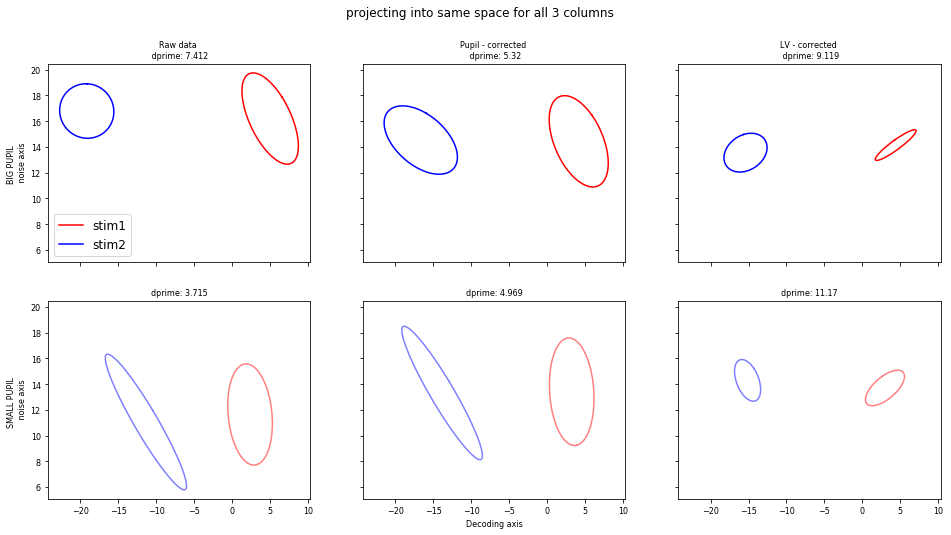

In [19]:
# plot the data
f, ax = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].set_title('Raw data \n dprime: {}'.format(dp_bp))
ax[0, 0].plot(r1_bp_el[0, :], r1_bp_el[1, :], color='red', label='stim1')
ax[0, 0].plot(r2_bp_el[0, :], r2_bp_el[1, :], color='blue', label='stim2')
ax[0, 0].set_ylabel('BIG PUPIL \n noise axis')
ax[0, 0].legend(fontsize=12)

ax[1, 0].set_title('dprime: {}'.format(dp_sp))
ax[1, 0].plot(r1_sp_el[0, :], r1_sp_el[1, :], color='red', alpha=0.5)
ax[1, 0].plot(r2_sp_el[0, :], r2_sp_el[1, :], color='blue', alpha=0.5)
ax[1, 0].set_ylabel('SMALL PUPIL \n noise axis')

# pupil-corrected
ax[0, 1].set_title('Pupil - corrected \n dprime: {}'.format(dp_pr_bp))
ax[0, 1].plot(r1_pr_bp_el[0, :], r1_pr_bp_el[1, :], color='red')
ax[0, 1].plot(r2_pr_bp_el[0, :], r2_pr_bp_el[1, :], color='blue')

ax[1, 1].set_title('dprime: {}'.format(dp_pr_sp))
ax[1, 1].plot(r1_pr_sp_el[0, :], r1_pr_sp_el[1, :], color='red', alpha=0.5)
ax[1, 1].plot(r2_pr_sp_el[0, :], r2_pr_sp_el[1, :], color='blue', alpha=0.5)
ax[1, 1].set_xlabel('Decoding axis')

# lv-corrected
ax[0, 2].set_title('LV - corrected \n dprime: {}'.format(dp_lvr_bp))
ax[0, 2].plot(r1_lvr_bp_el[0, :], r1_lvr_bp_el[1, :], color='red')
ax[0, 2].plot(r2_lvr_bp_el[0, :], r2_lvr_bp_el[1, :], color='blue')

ax[1, 2].set_title('dprime: {}'.format(dp_lvr_sp))
ax[1, 2].plot(r1_lvr_sp_el[0, :], r1_lvr_sp_el[1, :], color='red', alpha=0.5)
ax[1, 2].plot(r2_lvr_sp_el[0, :], r2_lvr_sp_el[1, :], color='blue', alpha=0.5)

f.suptitle("projecting into same space for all 3 columns")